In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import TimeSeriesSplit

import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Description of the Classification Problem

With the latest craze in cryptocurrency trading, there is a lot of speculation in the news about the trends in cryptocurrency prices. While similar to investment instruments (e.g. stocks, bonds), cryptocurrency are not strictly regulated by the SEC, and therefore, do not offer much financial information needed for fundamental analysis, calculating the cryptocurrency's intrinsic value. 

Therefore, to make sense of the price changes for cryptocurrency and uncover a pattern in this volatile market, this project aims to use supervised learning algorithms to figure out when to buy, sell, or hold Bitcoin, the most famous cryptocurrency.

From Kraken Exchange, Bitcoin's daily historical price and volume data from 2014 to Jan 2018 were pulled. This was used to derive key technical indicators to predict future price levels. 

* Bollinger Bands percentage: a volatility indicator which creates a band of 3 lines which are plotted in relation to a security's price

The output variable is the action: Strong Sell, Weak Sell, Hold, Weak Buy, and Strong Buy. These signals are based on the degree of the daily return. In this work, if the daily return exceeds 4% (decrease or increase), the signal is Strong. If the daily return is less than 4%, the signal is Weak. 

In summary, this project aims to classify different degrees of action on buying/selling Bitcoin based on its daily technical indicators. Because this is a time-series data, the data is not randomly split. Earlier data is used for training to test on the latter 33% of the data. 

In this work, cross-validation was not used because it violates the natural order of a time-series dataset. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem. We cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.


## 2. Metrics

### a. Training and Testing Error

a. Decision Tree
b. 

Training time. ROC curve

### b. Training Size vs. Performance

### c. Training time
learning curve

## 3. Analysis


Why did you get the results you did? Compare and contrast the different algorithms. 

What sort of changes might you make to each of those algorithms to improve performance? How fast were they in terms of wall clock time? Iterations? Would cross validation help (and if it would, why didn't you implement it?)? How much performance was due to the problems you chose? How about the values you chose for learning rates, stopping criteria, pruning methods, and so forth (and why doesn't your analysis show results for the different values you chose?)? Which algorithm performed best? How do you define best? Be creative and think of as many questions you can, and as many answers as you can.

-Why did you get the results you did? 

-Compare and contrast the different algorithms. 

-What sort of changes might you make to each of those algorithms to improve performance? 

-How fast were they in terms of wall clock time? Iterations? 

-Would cross validation help (and if it would, why didn't you implement it?)? How much performance was due to the 
problems you chose? 

-How about the values you chose for learning rates, stopping criteria, pruning methods, and so forth (and why doesn't your analysis show results for the different values you chose?)? 

-Which algorithm performed best? 

* How do you define best? 

In descending order from the Upper Band:

%B Above 1 = Price is Above the Upper Band

%B Equal to 1 = Price is at the Upper Band

%B Above .50 = Price is Above the Middle Line

%B Below .50 = Price is Below the Middle Line

%B Equal to 0 = Price is at the Lower Band

%B Below 0 = Price is Below the Lower Band

Generally speaking .80 and .20 are also relevant levels.

%B Above .80 = Price is Nearing the Upper Band
%B Below .20 = Price is Nearing the Lower Band

In [22]:
df = pd.read_csv('BTCUSDKraken.csv', index_col=0, usecols=['Date','Volume (BTC)', 'Weighted Price'])
df = df.drop('2018-01-12')
df = df.replace([0], np.nan)
df = df.ffill(axis=None, inplace=False, limit=None, downcast=None)
lookback = 3

delta = df['Weighted Price'].diff()
dUp, dDown = delta.copy(), delta.copy()
dUp[dUp < 0] = 0
dDown[dDown > 0] = 0

RolUp = pd.rolling_mean(dUp, lookback)
RolDown = pd.rolling_mean(dDown, lookback).abs()

df['RSI'] = RolUp / RolDown

sma = pd.rolling_mean(df['Weighted Price'], window = lookback, min_periods = lookback)
ema = pd.ewma(df['Weighted Price'], span = lookback, min_periods = lookback)
rolling_std = pd.rolling_std(df['Weighted Price'], window = lookback, min_periods = lookback)
up = (rolling_std * 2) + ema
down = (rolling_std * -2) + ema

#df['Price/SMA'] = df['Weighted Price']/sma
df['bbp'] = (df['Weighted Price'] - down) / (up - down)
df['Price/EMA'] = df['Weighted Price'] / ema
df['price_momentum'] = df['Weighted Price'].pct_change(periods = lookback - 1)
df['vol_momentum'] = df['Volume (BTC)'].pct_change(periods = lookback - 1)
df['bestaction'] = df['Weighted Price'].pct_change(periods = 1)

# suggestion_conditions = [
#     (df['Price/EMA'] < 0.97) & (df['bbp'] < 0.25),
#     (df['Price/EMA'] > 1.01) & (df['bbp'] > 0.75)]

actual_conditions = [
    (df['bestaction'] >= 0.04), 
    ( (0.04 > df['bestaction']) & (df['bestaction'] > 0) ),
    ( (0 > df['bestaction']) & (df['bestaction'] > -0.04) ),
    (df['bestaction'] <= -0.04) ]

choices = [2, 1, -1, -2]
#df['Suggestion'] = np.select(suggestion_conditions, choices, default=0)
df['Action'] = np.select(actual_conditions, choices, default=0)

df = df.drop(['Volume (BTC)', 'Weighted Price', 'bestaction'], axis=1)
df = df.drop(df.index[0:lookback])

df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

In [9]:
features = list(df.columns[0:-1])
X = df[features]
Y = df['Action']

#Shuffle = False b/c gotta train on earlier data and test on later data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [122]:
len(df)

1181

1. Model Complexity Experiments

Change the model by varying the hyperparameters of the model. 

You record RMSE errors in each case. (The k in kNN is a hyperparameter, the number of hidden nodes/layers, momentum and learning rates in a Neural Network are hyperparameters.)

We would like to figure out a way to pick hyperparameters and data sizes to get the "best" model we can, such that it performs optimally on the test data.  By best, we mean it is the model that best generalizes: it is the model with the least bias and least variance. We can't tune our model to test data directly, as this would bias our training to our test set (and defeat the purpose of creating a general model).


# 1. Decision Tree

In [95]:
max_depth = [5, 10, 20]
min_samples_split = [20, 10, 5, 2]
min_samples_leaf = [10, 5, 2, 1]

acc = 0
for i in max_depth:
    for j in min_samples_split:
        for k in min_samples_leaf:
            DT = DecisionTreeClassifier(max_depth=i, min_samples_split=j, min_samples_leaf=k)
            ypreds=DT.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | max_depth: %s | min_samples_split: %i | min_samples_leaf: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]

Accuracy: 0.77 | max_depth: 5 | min_samples_split: 20 | min_samples_leaf: 10
Accuracy: 0.77 | max_depth: 5 | min_samples_split: 10 | min_samples_leaf: 5
Accuracy: 0.80 | max_depth: 10 | min_samples_split: 20 | min_samples_leaf: 10
10 20 10


In [110]:
start = time.time()

max_depth = [5, 10, 20]
min_samples_split = [20, 10, 5, 2]
min_samples_leaf = [10, 5, 2, 1]

acc = 0
for i in max_depth:
    for j in min_samples_split:
        for k in min_samples_leaf:
            DT = DecisionTreeClassifier(max_depth=i, min_samples_split=j, min_samples_leaf=k)
            ypreds=DT.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | max_depth: %s | min_samples_split: %i | min_samples_leaf: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]

DT = DecisionTreeClassifier(max_depth=params[0], min_samples_split=params[1], min_samples_leaf=params[2])
DT.fit(X_train, Y_train)

DT_Ypreds = DT.predict(X_test)
DT_Ypreds_training = DT.predict(X_train)

DT_Training_Accuracy = accuracy_score(Y_train, DT_Ypreds_training)
DT_Testing_Accuracy = accuracy_score(Y_test, DT_Ypreds)

print ("Training Accuracy: %0.3f" % DT_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % DT_Testing_Accuracy)

end=time.time()

DT_time = end-start
print ("Time: %0.2f" % DT_time)

Accuracy: 0.77 | max_depth: 5 | min_samples_split: 20 | min_samples_leaf: 10
Accuracy: 0.77 | max_depth: 5 | min_samples_split: 10 | min_samples_leaf: 5
Accuracy: 0.80 | max_depth: 10 | min_samples_split: 20 | min_samples_leaf: 10
10 20 10
Training Accuracy: 0.839
Testing Accuracy: 0.741
Time: 0.15


This work used GridSearchCV to prune the Decision Tree. GridSearchCV runs through a list of parameters exhaustively and finds the best set of parameters in respect to accuracy via 8-fold Cross-Validation. 

This classifier uses the default Gini Impurity for the criterion. Gini Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Gini Impurity and Entropy typically yield very similar results, thus selection of this parameter is not prioritized. The minor difference is that Entorpy requires calculating log; using Gini as the criterion, therefore, can be a bit faster computationally. 

* min_samples_split feature refers to the minimum number of samples required to split an internal node. Smaller the min_samples_split, greater the tendency to overfit. 
* max_depth refers to the maximum depth of the tree. By default, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Greater the max_depth, greater the tendency to overfit. 
* min_samples_leaf refers to the minimum number of samples required to be at a leaf node. Smaller the min_samples_leaf, greater the tendency to overfit. 

# 2. Neural Networks (Multi-layer Perceptron (MLP) )


## Features:

NN = MLPClassifier(hidden_layer_sizes=(20, 5), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
 learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
 random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
 early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
 
* hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)

The ith element represents the number of neurons in the ith hidden layer.
hidden_layer_sizes=(10, 2) : 10 hidden layers with 2 hidden units

* activation : {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default ‘relu’
Activation function for the hidden layer.

* solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’
The solver for weight optimization.

* learning_rate_init : double, optional, default 0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.

* learning_rate : {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’
Learning rate schedule for weight updates.

* momentum : float, default 0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.

Neural Network is skewed by noise in the data. Neural networks, in general, require a very large amount of data to converge. Decision trees are great at filtering out noisy and low-information features, while a neural network might get caught up in their noise.

RMSD is the square root of the average of squared errors. Sensitive to outliers. Used for regression datasets. So the accuracy score is used instead. 

In [111]:
start = time.time()

hidden_layer_sizes = [(1, 5), (1, 10), (2,5), (2,10), (10, 5), (4, 20)]

acc = 0
for i in hidden_layer_sizes:
    NN = MLPClassifier(hidden_layer_sizes=i)
    ypreds=NN.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
    accuracy = accuracy_score(Y_train[500:], ypreds)
    if accuracy > acc:
        acc = accuracy
        print ("Accuracy: %0.2f | hidden_layer_sizes: %s" % (accuracy, str(i)))
        params=(i)
                
print params

NN = MLPClassifier(hidden_layer_sizes = params)
NN.fit(X_train, Y_train)

NN_Ypreds = NN.predict(X_test)
NN_Ypreds_training = NN.predict(X_train)

NN_Training_Accuracy = accuracy_score(Y_train, NN_Ypreds_training)
NN_Testing_Accuracy = accuracy_score(Y_test, NN_Ypreds)

print ("Training Accuracy: %0.3f" % NN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % NN_Testing_Accuracy)

end=time.time()

NN_time = end-start
print ("Time: %0.2f" % NN_time)

Accuracy: 0.48 | hidden_layer_sizes: (1, 5)
(1, 5)
Training Accuracy: 0.480
Testing Accuracy: 0.410
Time: 0.76


# 3. Boosting (AdaBoost on Decision Trees)



## Features:

1. n_estimators : integer, optional (default=10)
The number of trees in the forest.

2. learning_rate : float, optional (default=1.)
Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators. 

In [102]:
start = time.time()

n_estimators = [5, 10, 15, 20]
learning_rate = [1, 0.8, 0.5, 0.3]

acc = 0
for i in n_estimators:
    for j in learning_rate:
        Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_split=20, 
                                                          min_samples_leaf=10), 
                                  n_estimators=i, learning_rate=j)
        ypreds=Boost.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
        accuracy = accuracy_score(Y_train[500:], ypreds)
        if accuracy > acc:
            acc = accuracy
            print ("Accuracy: %0.2f | n_estimators: %i | learning_rate: %0.1f" % (accuracy, i, j))
            params=(i, j)
                
print params[0], params[1]

Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_split=15, 
                                                          min_samples_leaf=5), 
                                  n_estimators=params[0], learning_rate=params[1])
Boost.fit(X_train, Y_train)

Boost_Ypreds = Boost.predict(X_test)
Boost_Ypreds_training = Boost.predict(X_train)

Boost_Training_Accuracy = accuracy_score(Y_train, Boost_Ypreds_training)
Boost_Testing_Accuracy = accuracy_score(Y_test, Boost_Ypreds)

print ("Training Accuracy: %0.3f" % Boost_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % Boost_Testing_Accuracy)

end=time.time()

Boost_time = end - start
print ("Time: %0.2f" % Boost_time)

Accuracy: 0.73 | n_estimators: 5 | learning_rate: 1.0
Accuracy: 0.77 | n_estimators: 5 | learning_rate: 0.8
Accuracy: 0.82 | n_estimators: 10 | learning_rate: 0.8
10 0.8
Training Accuracy: 0.997
Testing Accuracy: 0.744
Time: 1.22


# 4. SVM

-at least 2 kernel functions

Pros: 
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Cons:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

## Features:

1. Kernel(Linear, RBF, poly, sigmoid, precomputed)

Linear kernel = Straight Line (hyperplane) as the decision boundary
* rarely used in practice

Radial Basis Function (RBF) = commonly used kernel in SVC
2 parameters:
* gamma
* C

2. Gamma:
*  'spread' of the kernel and therefore the decision region.
* low gamma -> the 'curve' of the decision boundary is very low and thus the decision region is very broad (underfitting)
* gamma = 10 (The decision boundary starts to be highly effected by individual data points (i.e. variance)).
* high gamma -> the 'curve' of the decision boundary is high, which creates islands of decision-boundaries around data points (overfitting)
* If gamma is ‘auto’ then 1/n_features will be used instead.
* gamma defines how much influence a single training example has. 
* The larger gamma is, the closer other examples must be to be affected.

3. C:
* trades off misclassification of training examples against simplicity of the decision surface
* A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly
* penalty for misclassifying a data point
* small C -> classifier is okay with misclassified data points (high bias, low variance)
* big C -> classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance)

C > 10 is too slow

4. degree : int, optional (default=3)
* Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

SVM = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)

In [105]:
start = time.time()

kernel = ['rbf', 'sigmoid']
gamma = [0.001, 0.0001]
C = [1, 10, 100, 1000]

acc = 0
for i in kernel:
    for j in gamma:
        for k in C:
            SVM = SVC(kernel=i, gamma=j, C=k)
            ypreds=SVM.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | kernel: %s | gamma: %0.03f | C: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]

SVM = SVC(kernel=params[0], gamma=params[1], C=params[2])
SVM.fit(X_train, Y_train)

SVM_Ypreds = SVM.predict(X_test)
SVM_Ypreds_training = SVM.predict(X_train)

SVM_Training_Accuracy = accuracy_score(Y_train, SVM_Ypreds_training)
SVM_Testing_Accuracy = accuracy_score(Y_test, SVM_Ypreds)

print ("Training Accuracy: %0.3f" % SVM_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % SVM_Testing_Accuracy)

end=time.time()

SVM_time = end - start
print ("Time: %0.2f" % SVM_time)

Accuracy: 0.49 | kernel: rbf | gamma: 0.001 | C: 1
Accuracy: 0.59 | kernel: rbf | gamma: 0.001 | C: 100
Accuracy: 0.75 | kernel: rbf | gamma: 0.001 | C: 1000
rbf 0.001 1000
Training Accuracy: 0.721
Testing Accuracy: 0.610
Time: 0.35


# 5. KNN

In [103]:
start = time.time()

weights = ['uniform', 'distance']
n_neighbors = [30, 20, 10, 5, 3, 2]
leaf_size = [30, 20, 10]

acc = 0
for i in weights:
    for j in n_neighbors:
        for k in leaf_size:
            KNN = KNeighborsClassifier(weights=i, n_neighbors=j, leaf_size=k)
            ypreds=KNN.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | weights: %s | n_neighbors: %i | leaf_size: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]

KNN = KNeighborsClassifier(weights=params[0], n_neighbors=params[1], leaf_size=params[2])
KNN.fit(X_train, Y_train)

KNN_Ypreds = KNN.predict(X_test)
KNN_Ypreds_training = KNN.predict(X_train)

KNN_Training_Accuracy = accuracy_score(Y_train, KNN_Ypreds_training)
KNN_Testing_Accuracy = accuracy_score(Y_test, KNN_Ypreds)

print ("Training Accuracy: %0.3f" % KNN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % KNN_Testing_Accuracy)

end=time.time()

KNN_time = end - start
print ("Time: %0.2f" % KNN_time)

Accuracy: 0.52 | weights: uniform | n_neighbors: 30 | leaf_size: 30
Accuracy: 0.54 | weights: uniform | n_neighbors: 10 | leaf_size: 30
Accuracy: 0.54 | weights: uniform | n_neighbors: 5 | leaf_size: 30
Accuracy: 0.56 | weights: distance | n_neighbors: 30 | leaf_size: 30
distance 30 30
Training Accuracy: 1.000
Testing Accuracy: 0.536
Time: 0.16


## Features:

1. weights : str or callable, optional (default = ‘uniform’)
weight function used in prediction. Possible values:

* uniform : uniform weights. All points in each neighborhood are weighted equally.

* distance : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                           leaf_size=30, p=2, metric='minkowski', metric_params=None, 
                           n_jobs=1)

## II. Model Comparison

## 1. ROC Curves

In [112]:
times = [DT_time, NN_time, Boost_time, SVM_time, KNN_time]
Training_Accuracy = [DT_Training_Accuracy, NN_Training_Accuracy, Boost_Training_Accuracy, SVM_Training_Accuracy, KNN_Training_Accuracy]
Testing_Accuracy = [DT_Testing_Accuracy, NN_Testing_Accuracy, Boost_Testing_Accuracy, SVM_Testing_Accuracy, KNN_Testing_Accuracy]

result = pd.DataFrame([times, Training_Accuracy, Testing_Accuracy], columns=["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"], index=['Running Time (seconds)', 'Traing Accuracy', 'Testing Accuracy'])


In [113]:
result

,Decision Tree,Neural Network,AdaBoost,SVM,KNN
Running Time (seconds),0.146005,0.761759,1.219080,0.346011,0.156177
Traing Accuracy,0.839444,0.480405,0.997472,0.720607,1.000000
Testing Accuracy,0.741026,0.410256,0.743590,0.610256,0.535897


In [114]:
names = ["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"]

classifiers = [DT, NN, Boost, SVM, KNN]

In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 34  10   0   0]
 [ 10 119  28   1]
 [  1  25 105   9]
 [  0   0  17  31]]
Normalized confusion matrix
[[ 0.77  0.23  0.    0.  ]
 [ 0.06  0.75  0.18  0.01]
 [ 0.01  0.18  0.75  0.06]
 [ 0.    0.    0.35  0.65]]
Confusion matrix, without normalization
[[  0  41   3   0]
 [  0 123  35   0]
 [  0 103  37   0]
 [  0  32  16   0]]
Normalized confusion matrix
[[ 0.    0.93  0.07  0.  ]
 [ 0.    0.78  0.22  0.  ]
 [ 0.    0.74  0.26  0.  ]
 [ 0.    0.67  0.33  0.  ]]
Confusion matrix, without normalization
[[ 32  11   1   0]
 [  3 120  35   0]
 [  0  26 106   8]
 [  0   1  15  32]]
Normalized confusion matrix
[[ 0.73  0.25  0.02  0.  ]
 [ 0.02  0.76  0.22  0.  ]
 [ 0.    0.19  0.76  0.06]
 [ 0.    0.02  0.31  0.67]]
Confusion matrix, without normalization
[[  0  44   0   0]
 [  0 126  31   1]
 [  0  28 110   2]
 [  0   4  42   2]]
Normalized confusion matrix
[[ 0.    1.    0.    0.  ]
 [ 0.    0.8   0.2   0.01]
 [ 0.    0.2   0.79  0.01]
 [ 0.    0.0

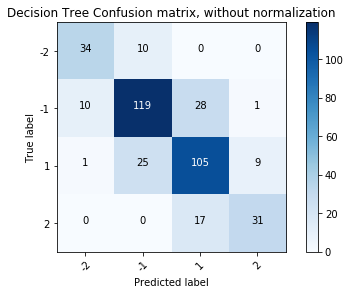

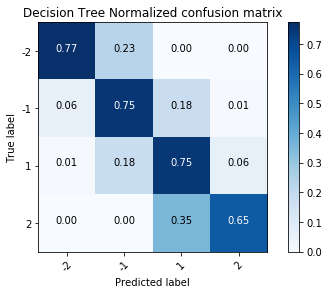

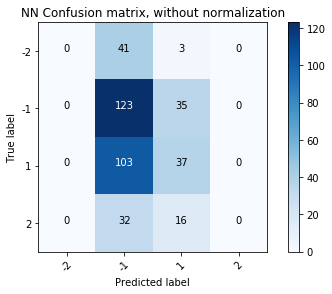

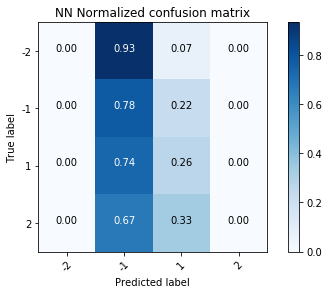

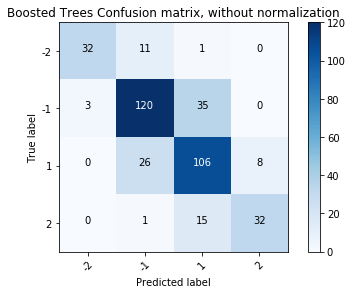

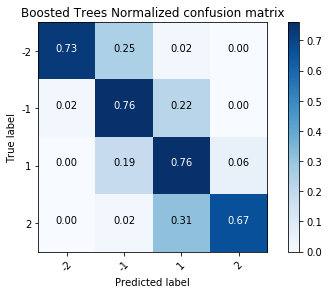

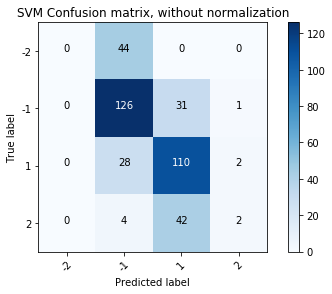

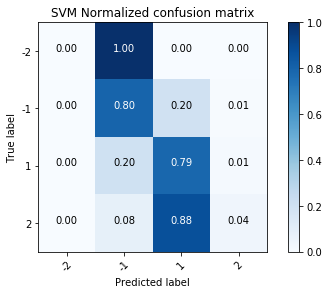

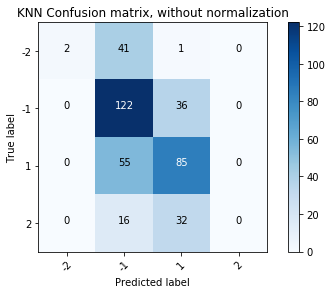

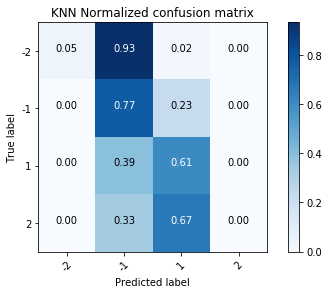

In [116]:
class_names = [-2, -1, 1, 2]

DT_cnf_matrix = confusion_matrix(Y_test, DT_Ypreds)
np.set_printoptions(precision=2)

####################################################################

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names,
                      title='Decision Tree Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names, normalize=True,
                      title='Decision Tree Normalized confusion matrix')
####################################################################

NN_cnf_matrix = confusion_matrix(Y_test, NN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=class_names,
                      title='NN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=class_names, normalize=True,
                      title='NN Normalized confusion matrix')
####################################################################

Boost_cnf_matrix = confusion_matrix(Y_test, Boost_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names,
                      title='Boosted Trees Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names, normalize=True,
                      title='Boosted Trees Normalized confusion matrix')
####################################################################

SVM_cnf_matrix = confusion_matrix(Y_test, SVM_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names, normalize=True,
                      title='SVM Normalized confusion matrix')
####################################################################
KNN_cnf_matrix = confusion_matrix(Y_test, KNN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names,
                      title='KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names, normalize=True,
                      title='KNN Normalized confusion matrix')


plt.show()

In [117]:
#from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

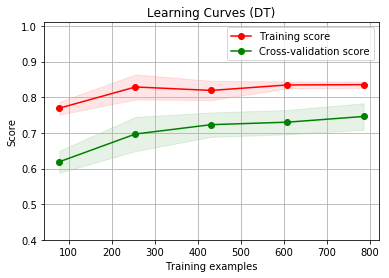

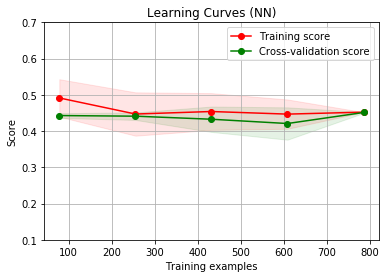

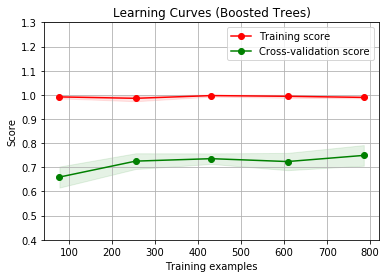

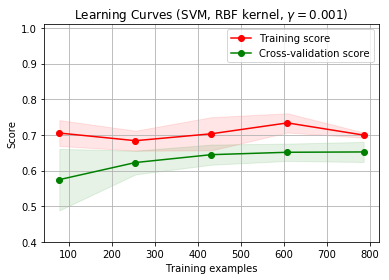

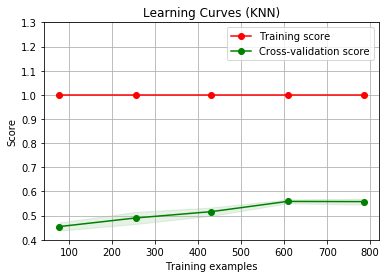

In [120]:
title = "Learning Curves (DT)"

plot_learning_curve(DT, title, X, Y, ylim=(0.4, 1.01))
####################################################################

title = "Learning Curves (NN)"
plot_learning_curve(NN, title, X, Y, (0.3, 0.6))

####################################################################

title = "Learning Curves (Boosted Trees)"
plot_learning_curve(Boost, title, X, Y, (0.4, 1.3))

####################################################################

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(SVM, title, X, Y, (0.4, 0.9))
####################################################################

title = "Learning Curves (KNN)"
plot_learning_curve(KNN, title, X, Y, (0.4, 1.3))
####################################################################

plt.show()